In [1]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

In [2]:
current_directory = os.getcwd()
data_df = pd.read_csv(current_directory + '/input/processed_data/tweets_and_stock.csv')

In [3]:
data_df['date'] = pd.to_datetime(data_df['date'])
data_df['date'] = data_df['date'].dt.date
data_df = data_df.sort_values(by="date")
data_df.head()

,ticker_symbol,date,year,month,day,close_value,average_afinn_score,vader_sentiment_negative,vader_sentiment_neutral,vader_sentiment_positive,tweet_count,tweet_total_engagement
0,MSFT,2015-01-01,2015,1,1,46.45,0.333333,0.0,1.0,0.0,30,72
1,AAPL,2015-01-01,2015,1,1,110.38,0.477707,0.0,1.0,0.0,155,1699
2,TSLA,2015-01-01,2015,1,1,222.41,0.253968,0.0,1.0,0.0,63,167
3,GOOG,2015-01-01,2015,1,1,526.40,1.210526,0.0,0.0,1.0,19,36
4,AMZN,2015-01-01,2015,1,1,310.35,-0.796610,0.0,0.0,1.0,59,936


In [4]:
tsla_df = data_df[data_df['ticker_symbol'] == "TSLA"]
tsla_df = tsla_df.drop(columns=['ticker_symbol'])
tsla_df = tsla_df.sort_values(by="date")
tsla_df = tsla_df.reset_index(drop=True)
tsla_df.head()

,date,year,month,day,close_value,average_afinn_score,vader_sentiment_negative,vader_sentiment_neutral,vader_sentiment_positive,tweet_count,tweet_total_engagement
0,2015-01-01,2015,1,1,222.41,0.253968,0.0,1.0,0.0,63,167
1,2015-01-02,2015,1,2,219.31,0.536364,0.0,1.0,0.0,110,218
2,2015-01-03,2015,1,3,219.31,0.256757,0.0,1.0,0.0,74,147
3,2015-01-04,2015,1,4,219.31,0.290909,0.0,1.0,0.0,55,98
4,2015-01-05,2015,1,5,210.09,0.644444,0.0,1.0,0.0,134,309


In [5]:
tsla_df_x = tsla_df.drop(columns = ['close_value'])
tsla_df_y = tsla_df['close_value']
tsla_df_x_train, tsla_df_x_test, tsla_df_y_train, tsla_df_y_test = train_test_split(tsla_df_x, tsla_df_y, test_size=0.2, random_state=42)

In [6]:
x_drop_columns = ['date']
x_train, x_test = tsla_df_x_train.drop(columns=x_drop_columns), tsla_df_x_test.drop(columns=x_drop_columns)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train, y_test = tsla_df_y_train, tsla_df_y_test

In [7]:
# Draw line graph to compare actual vs predicted
def drawComparisionGraph(dates, y_test, y_pred):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

    final_pred = pd.DataFrame({'date': dates,'y_test': y_test, 'y_pred': y_pred})
    final_pred = final_pred.sort_values(by='date')
    
    plt.figure(figsize=(10, 6))
    plt.plot(final_pred['date'], final_pred['y_test'], label='Actual (y_test)', linestyle='-', color='b')
    plt.plot(final_pred['date'], final_pred['y_pred'], label='Predicted (y_pred)', linestyle='-', color='g')
    plt.title("Actual vs. Predicted Values Over Time")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

Mean Squared Error: 1831.623638717818
R-squared: 0.42542457397920264


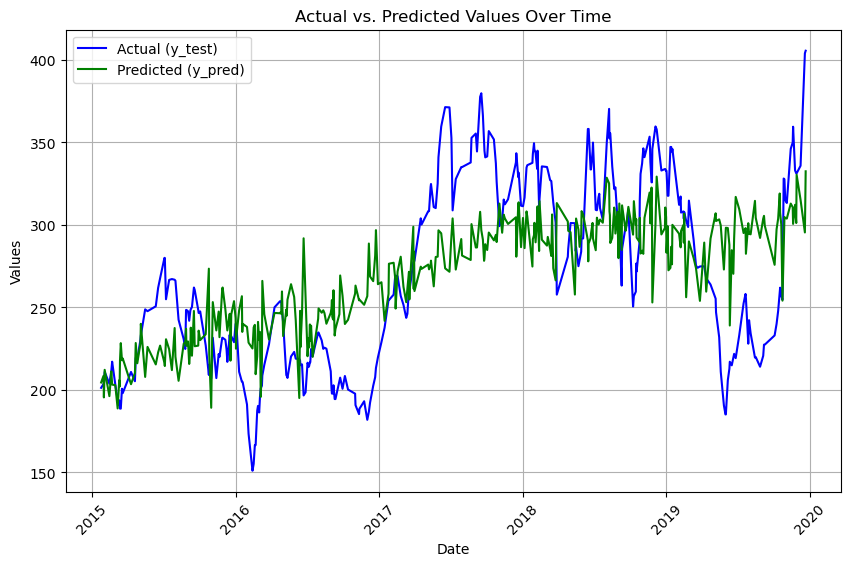

In [8]:
# Linear Regression

linear_regression_model = LinearRegression()

linear_regression_model.fit(x_train, y_train)

linear_regression_y_pred = linear_regression_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, linear_regression_y_pred)

Mean Squared Error: 123.21798956784157
R-squared: 0.9613468469434424


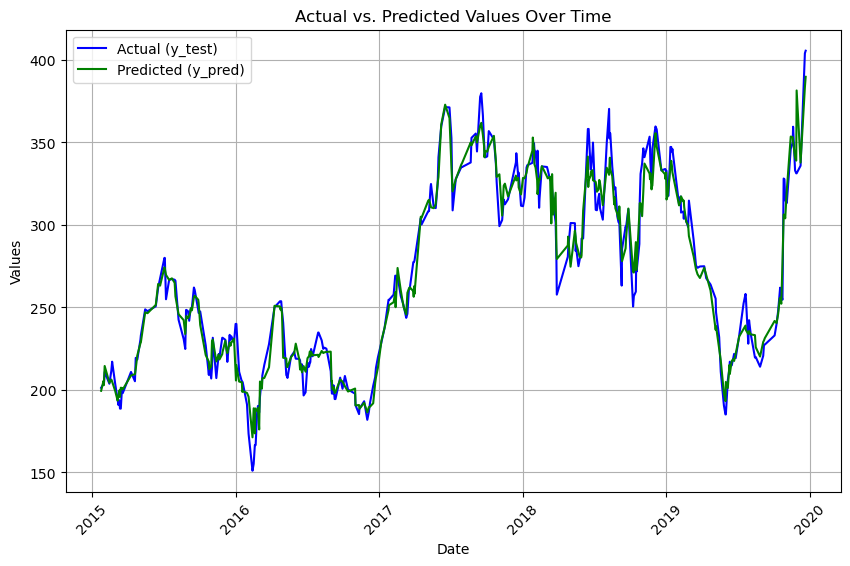

In [9]:
# Random Forest Regression

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest_model.fit(x_train, y_train)

y_pred = random_forest_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Mean Squared Error: 126.03825078160446
R-squared: 0.9604621385600531


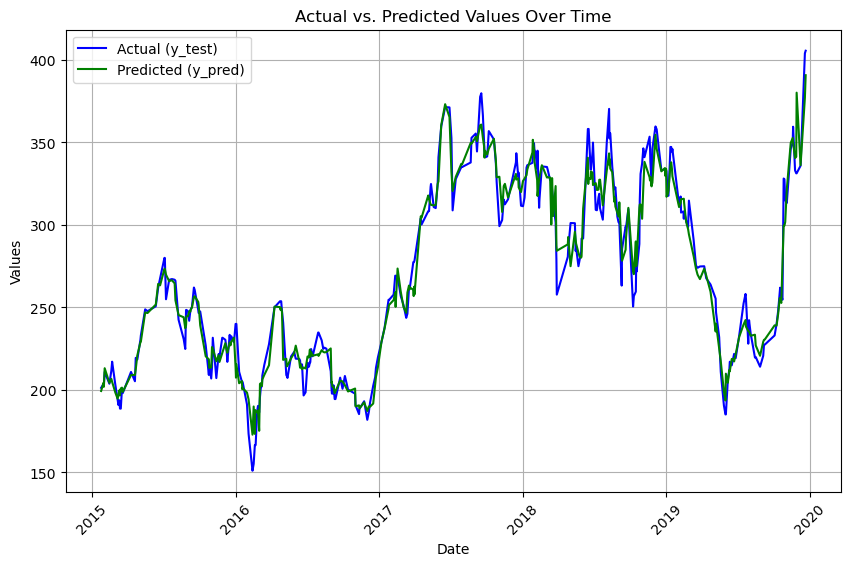

In [10]:
# Random Forest Regression Cross Validation

# Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Create the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_random_forest_model = grid_search.best_estimator_

# Fit the best model on the training data
best_random_forest_model.fit(x_train, y_train)

# Make predictions on the test data
random_forest_y_pred = best_random_forest_model.predict(x_test)

print("Best Hyperparameters: \n", best_params)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, random_forest_y_pred)

Mean Squared Error: 1831.847837346668
R-squared: 0.4253542434702696


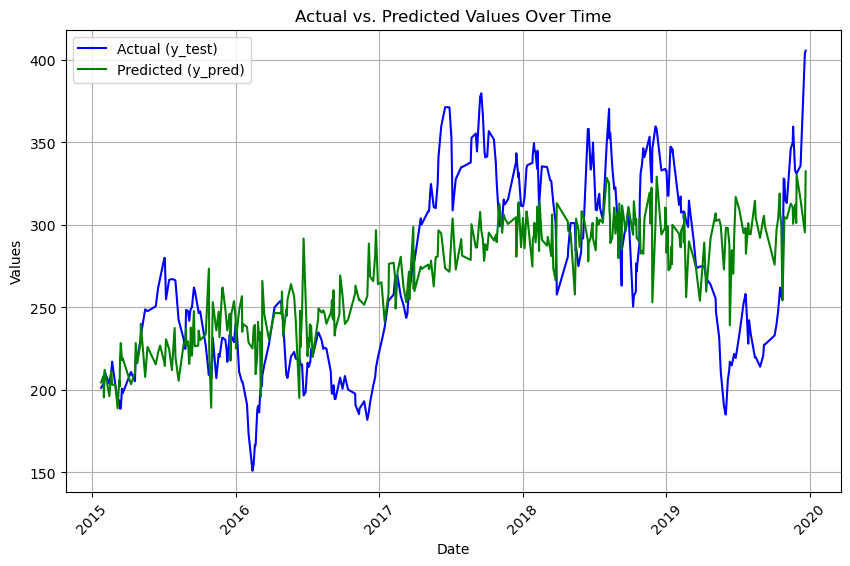

In [11]:
# Ridge Regression

ridge_model = Ridge(alpha=0.1)

ridge_model.fit(x_train, y_train)

y_pred = ridge_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 1

Mean Squared Error: 1833.8910766481454
R-squared: 0.42471328477805126


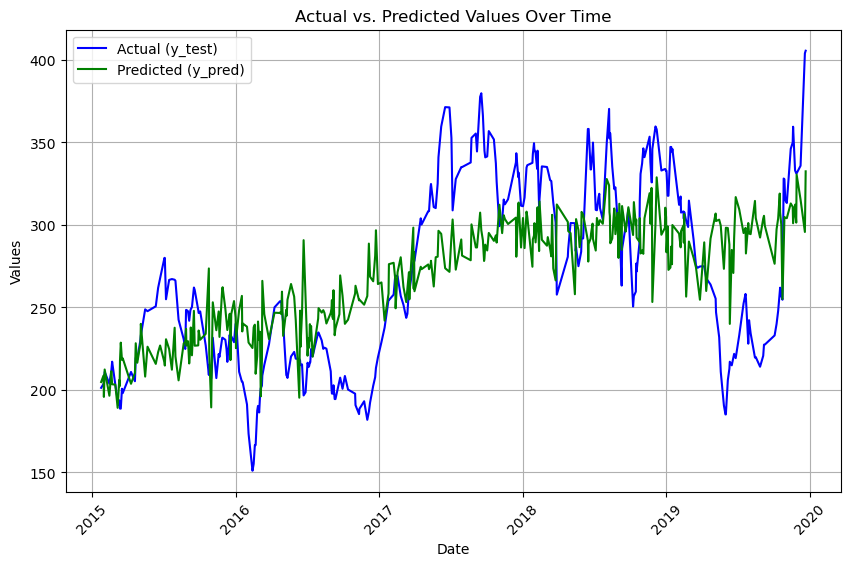

In [12]:
# Ridge Regression Cross Validation

# Define a range of alpha values to test
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Create the Ridge Regression model
model = Ridge()

# Perform grid search with cross-validation (e.g., 5-fold)
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best alpha value and the best model
best_alpha = grid_search.best_params_['alpha']
best_ridge_model = grid_search.best_estimator_

# Fit the best model on the training data
best_ridge_model.fit(x_train, y_train)

# Make predictions on the test data
ridge_y_pred = best_ridge_model.predict(x_test)

print("Best Hyperparameters: \n", best_alpha)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, ridge_y_pred)

Mean Squared Error: 192.47397814207648
R-squared: 0.9396214289599814


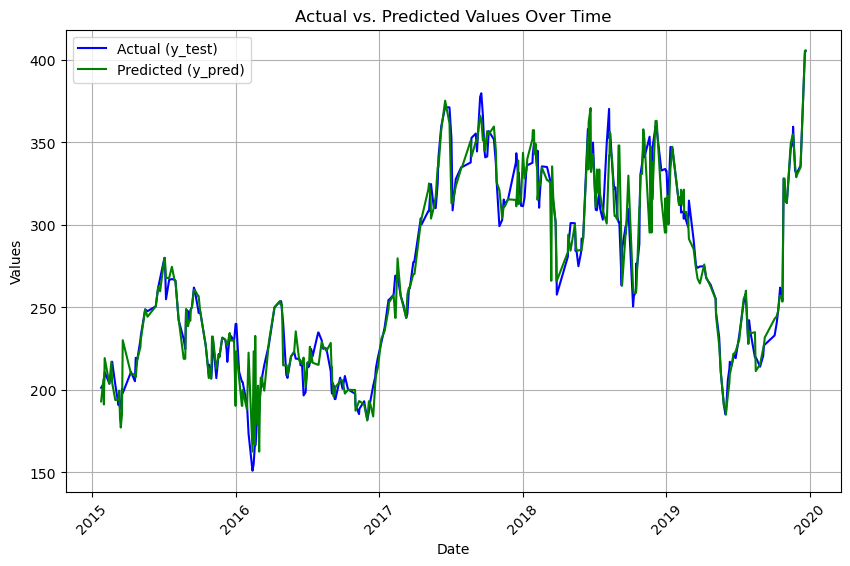

In [13]:
# Decision Tree Regression

decision_tree_model = DecisionTreeRegressor()

decision_tree_model.fit(x_train, y_train)

y_pred = decision_tree_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

Mean Squared Error: 155.97696271416785
R-squared: 0.9510704448738936


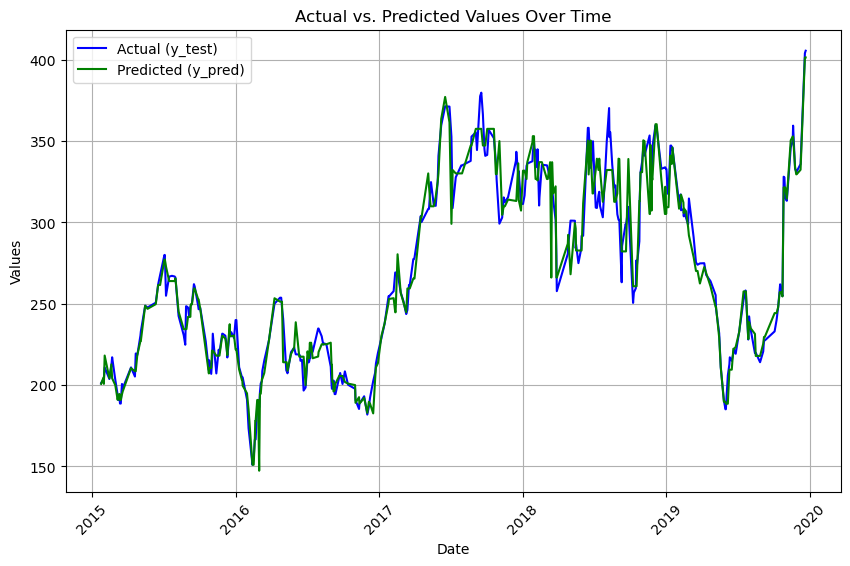

In [14]:
# Decision Tree Regression Cross Validation

# Define the hyperparameters and their possible values for tuning
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

# Create the Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=42)

# Perform grid search with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_decision_tree_model = grid_search.best_estimator_

# Fit the best model on the training data
best_decision_tree_model.fit(x_train, y_train)

# Make predictions on the test data
decision_tree_y_pred = best_decision_tree_model.predict(x_test)

print("Best Hyperparameters: \n", best_params)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, decision_tree_y_pred)

Mean Squared Error: 378.0136017988173
R-squared: 0.8814181463353165


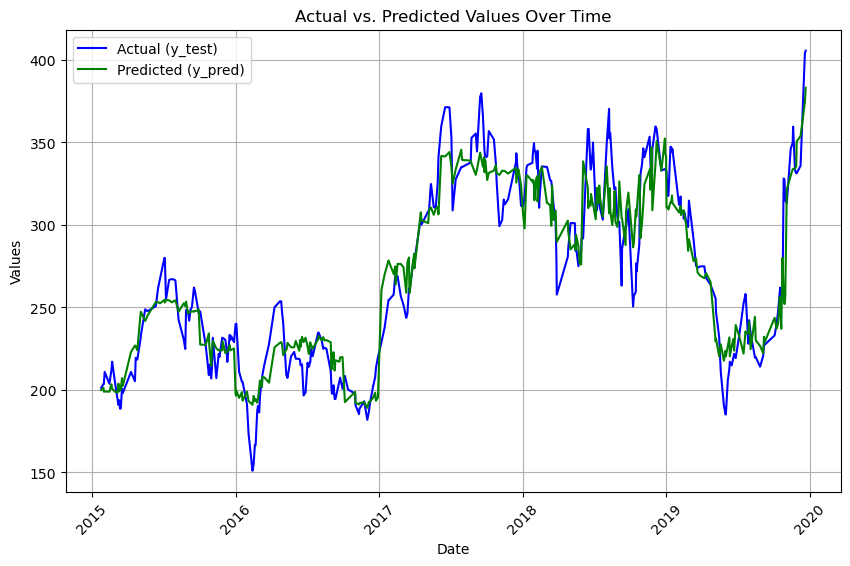

In [15]:
# Gradient Boosting Regression

gradient_boosting_model = GradientBoostingRegressor()

gradient_boosting_model.fit(x_train, y_train)

y_pred = gradient_boosting_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 0.8}

Mean Squared Error: 232.2116933681337
R-squared: 0.9271558142056926


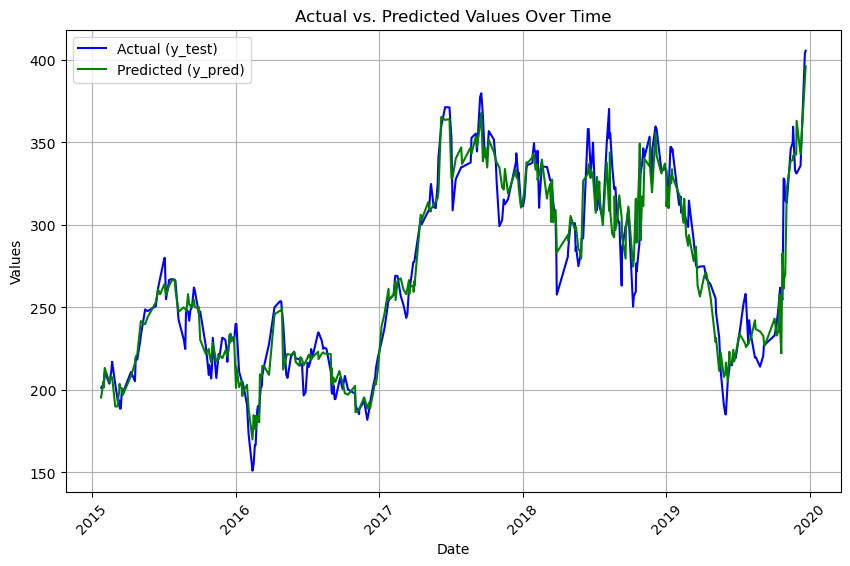

In [16]:
# Gradient Boosting Regression Cross Validation

# Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'min_samples_split': [2, 4, 8],
}

# Create the GradientBoostingRegressor model
model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_gradient_boosting_model = grid_search.best_estimator_

# Fit the best model on the training data
best_gradient_boosting_model.fit(x_train, y_train)

# Make predictions on the test data
gradient_boosting_y_pred = best_gradient_boosting_model.predict(x_test)

print("Best Hyperparameters: \n", best_params)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, gradient_boosting_y_pred)

Mean Squared Error: 710.625696738388
R-squared: 0.7770786236791468


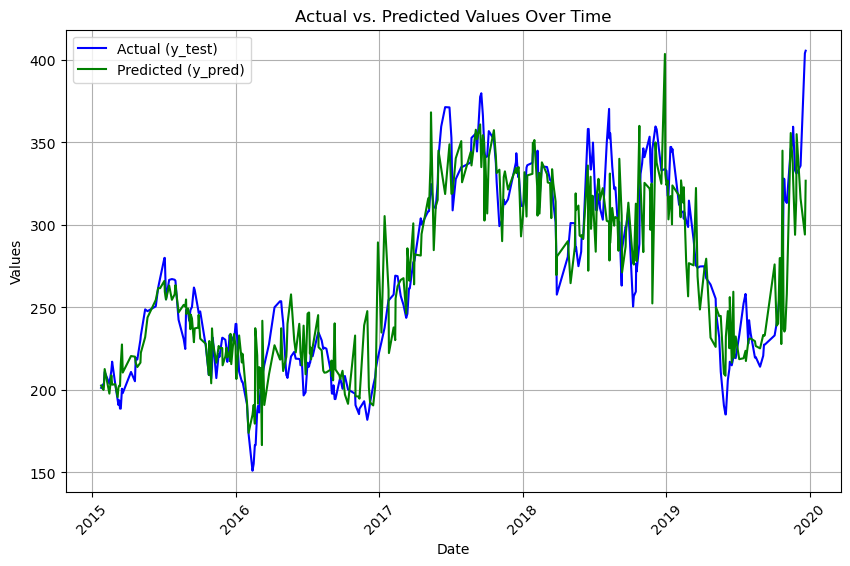

In [17]:
# K-Nearest Neighbors (KNN) Regression

k_nearest_neighbors_model = KNeighborsRegressor(n_neighbors=4)

k_nearest_neighbors_model.fit(x_train, y_train)

y_pred = k_nearest_neighbors_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 3

Mean Squared Error: 672.1678380009107
R-squared: 0.7891427508834681


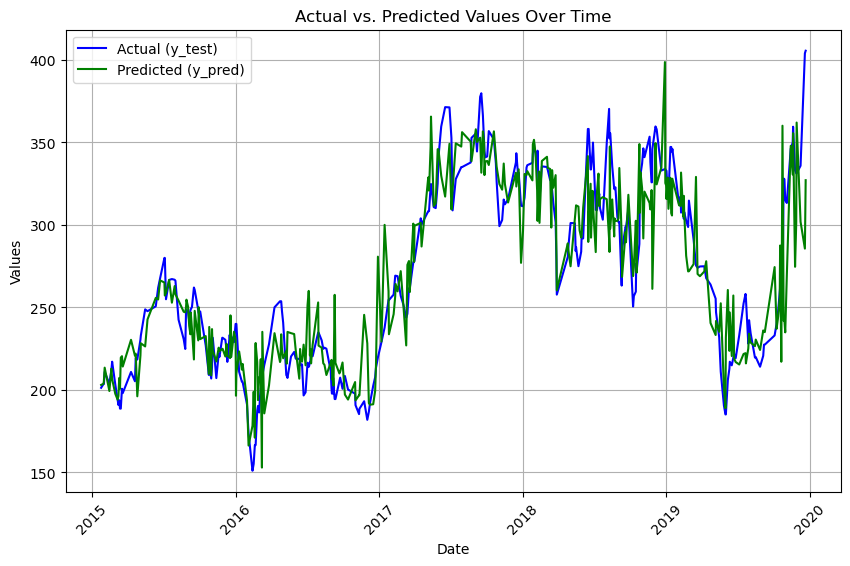

In [18]:
# K-Nearest Neighbors (KNN) Regression Cross Validation

# Define a list of n_neighbors values to test
n_neighbors_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create an empty dictionary to store the results
results = {}

# Iterate over the n_neighbors values
for n_neighbors in n_neighbors_values:
    # Create a KNeighborsRegressor model with the current n_neighbors value
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    # Perform k-fold cross-validation (e.g., 5-fold) and compute the mean squared error
    mse_scores = -cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Store the mean of the MSE scores in the results dictionary
    results[n_neighbors] = np.mean(mse_scores)

# Find the best n_neighbors value (the one with the lowest MSE)
best_n_neighbors = min(results, key=results.get)

# Train the model with the best n_neighbors value on the full training data
best_k_nearest_neighbors_model = KNeighborsRegressor(n_neighbors=best_n_neighbors)
best_k_nearest_neighbors_model.fit(x_train, y_train)

# Make predictions on the test data
k_nearest_neighbors_y_pred = best_k_nearest_neighbors_model.predict(x_test)

print("Best Hyperparameters: \n", best_n_neighbors)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, k_nearest_neighbors_y_pred)

Mean Squared Error: 3180.192252300664
R-squared: 0.002382214572847041


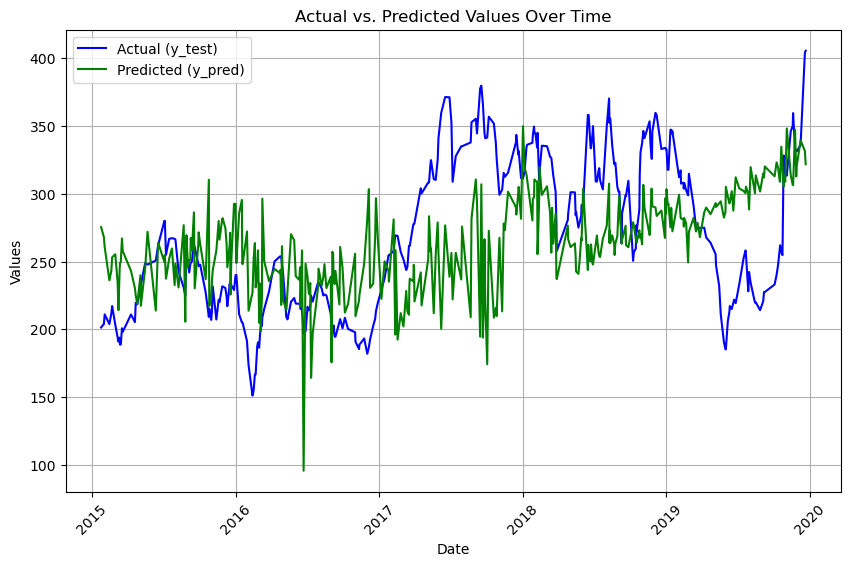

In [19]:
# Neural Network Regression

neural_network_model = MLPRegressor(random_state=42)

neural_network_model.fit(x_train, y_train)

y_pred = neural_network_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'solver': 'lbfgs'}

Mean Squared Error: 303.4077107213712
R-squared: 0.9048218143942701


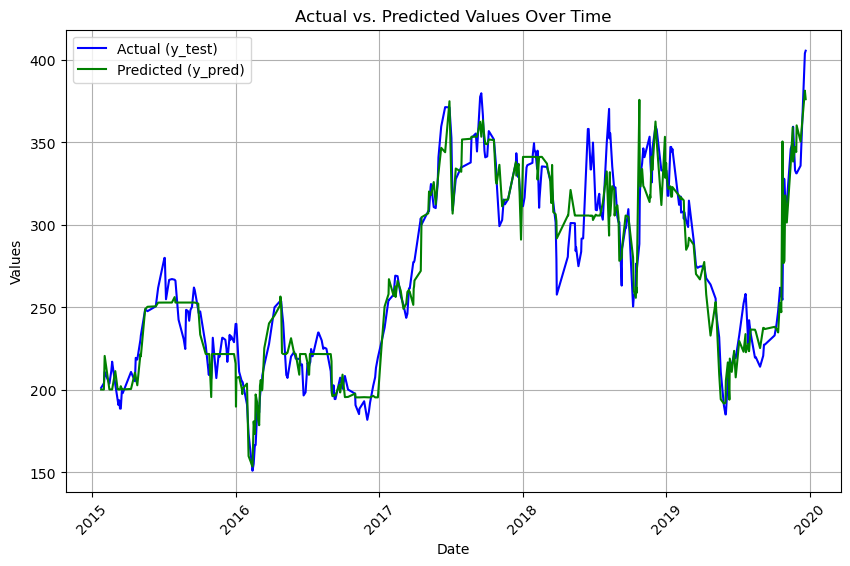

In [20]:
# Define the hyperparameters and their possible values for tuning
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Create the MLPRegressor model
model = MLPRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_neural_network_model = grid_search.best_estimator_

# Fit the best model on the training data
best_neural_network_model.fit(x_train, y_train)

# Make predictions on the test data
neural_network_y_pred = best_neural_network_model.predict(x_test)

print("Best Hyperparameters: \n", best_params)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, neural_network_y_pred)

Mean Squared Error: 1944.5977312670263
R-squared: 0.38998490395986696


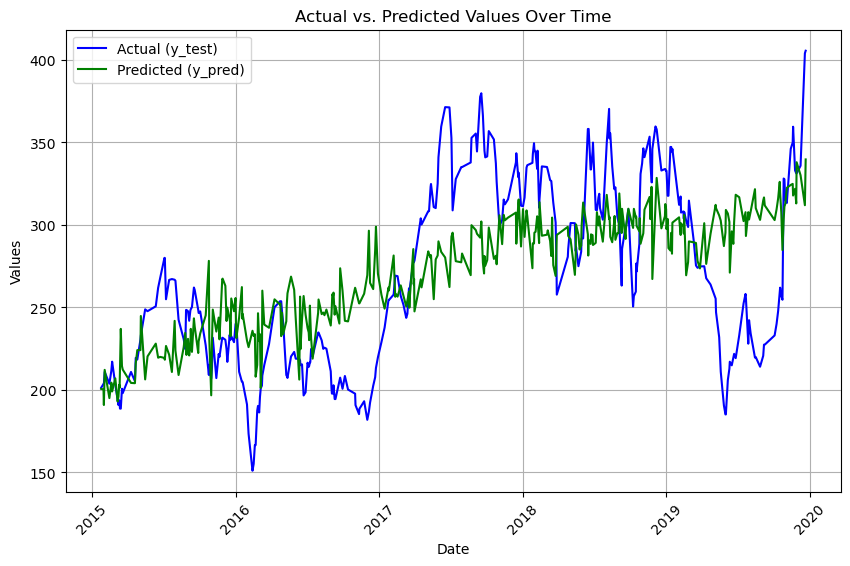

In [21]:
# Support Vector Regression

support_vector_model = SVR(kernel='linear')

support_vector_model.fit(x_train, y_train)

y_pred = support_vector_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 {'C': 10, 'epsilon': 1}

Mean Squared Error: 1842.926859227709
R-squared: 0.4218787840021614


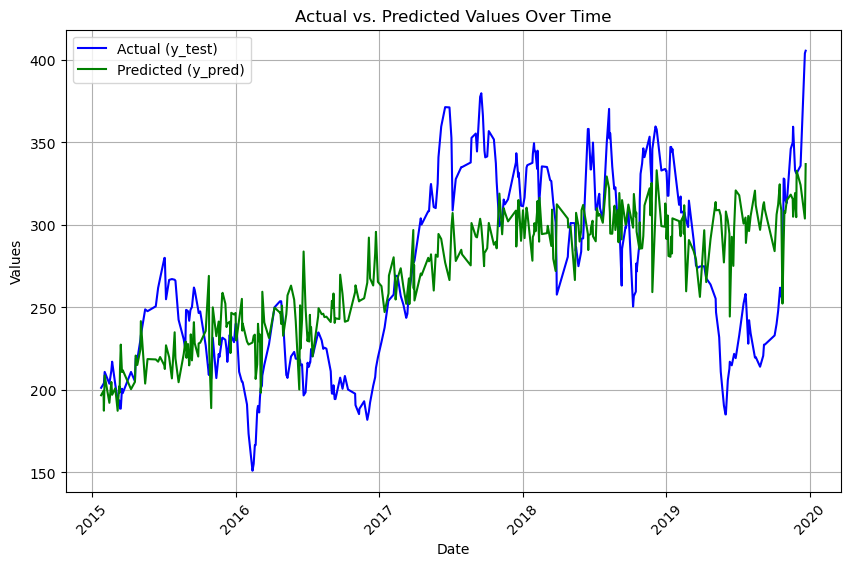

In [22]:
# Support Vector Regressor Cross Vaidation

# Define the hyperparameters and their possible values for tuning
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
}

# Create the SVR model
model = SVR(kernel='linear')

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_support_vector_model = grid_search.best_estimator_

# Fit the best model on the training data
best_support_vector_model.fit(x_train, y_train)

# Make predictions on the test data
supprot_vector_y_pred = best_support_vector_model.predict(x_test)

print("Best Hyperparameters: \n", best_params)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, supprot_vector_y_pred)

Mean Squared Error: 425.8507911394417
R-squared: 0.8664117482609458


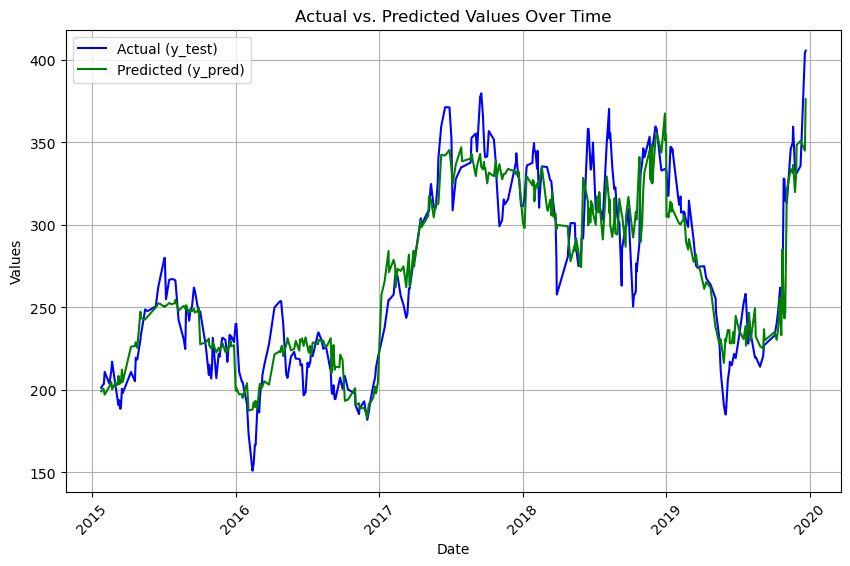

In [23]:
# XGBoost Regressor

xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=3,                  # Maximum depth of the trees
    subsample=0.8,                # Fraction of samples used for training
    colsample_bytree=0.8,         # Fraction of features used for training
    random_state=42               # Seed for reproducibility
)

xgboost_model.fit(x_train, y_train)

y_pred = xgboost_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

Best Hyperparameters: 
 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}

Mean Squared Error: 206.35293406215666
R-squared: 0.93526763768871


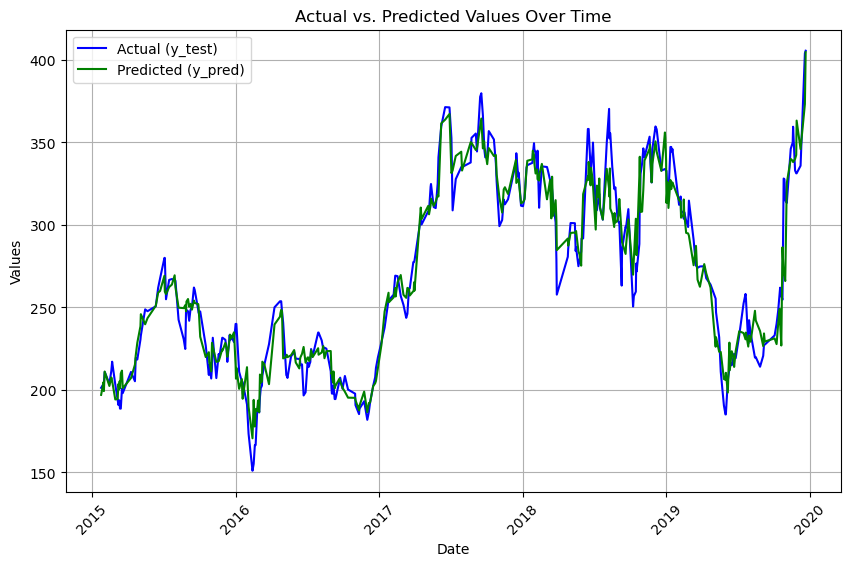

In [24]:
# XGBoost Regressor Cross Validation

# Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Create the XGBoost Regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform grid search with cross-validation (e.g., 5-fold)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_xgboost_model = grid_search.best_estimator_

# Fit the best model on the training data
best_xgboost_model.fit(x_train, y_train)

# Make predictions on the test data
xgboost_y_pred = best_xgboost_model.predict(x_test)

print("Best Hyperparameters: \n", best_params)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, xgboost_y_pred)

In [ ]:
# Catboost Regressor

catboost_model = cb.CatBoostRegressor(
    iterations=300,
    learning_rate=0.2,
    depth=4,
    silent=True
)

catboost_model.fit(x_train, y_train)

y_pred = catboost_model.predict(x_test)

drawComparisionGraph(tsla_df_x_test['date'], y_test, y_pred)

In [ ]:
# Catboost Regressor After Cross Validation

catboost_param_grid = {
    'iterations': [300, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
}

model = cb.CatBoostRegressor(silent=True, random_state=42)

# Perform grid search with cross-validation (e.g., 5-fold)
catboost_grid_search = GridSearchCV(model, catboost_param_grid, cv=5, scoring='neg_mean_squared_error')
catboost_grid_search.fit(x_train, y_train)

# Get the best hyperparameters and the best model
best_catboost_params = catboost_grid_search.best_params_
best_catboost_model = catboost_grid_search.best_estimator_

# Fit the best model on the training data
best_catboost_model.fit(x_train, y_train)

# Make predictions on the test data
catboost_y_pred = best_catboost_model.predict(x_test)

print("Best CatBoost Hyperparameters: \n", best_catboost_params)
print()
drawComparisionGraph(tsla_df_x_test['date'], y_test, catboost_y_pred)

In [25]:
# Create Combine Prediction df.

prediction_df = pd.DataFrame({
    'Linear Regression': linear_regression_y_pred,
    'Ridge Regression': ridge_y_pred,
    'Random Forest Regression': random_forest_y_pred,
    'Decision Tree Regression': decision_tree_y_pred,
    'Support Vector Regression': supprot_vector_y_pred,
    'K-Nearest Neighbors Regression': k_nearest_neighbors_y_pred,
    'Gradient Boosting Regression': gradient_boosting_y_pred,
    'Neural Network Regression': neural_network_y_pred,
    'XGBoost Regressor': xgboost_y_pred,
    'CatBoost Regressor': catboost_y_pred
})

In [26]:
metrics = {
    'model': [],
    'mean_squared_error': [],
    'r2_score': []
}

for model, y_pred in prediction_df.items():
    mean_squared_error_value = mean_squared_error(y_test, y_pred)
    r2_score_value = r2_score(y_test, y_pred)
    metrics['model'].append(model)
    metrics['mean_squared_error'].append(round(mean_squared_error_value, 4))
    metrics['r2_score'].append(round(r2_score_value, 4))
    
metrics_df = pd.DataFrame(metrics)

metrics_df = metrics_df.sort_values(by="mean_squared_error", ascending=True)

metrics_df

,model,mean_squared_error,r2_score
2,Random Forest Regression,126.0383,0.9605
3,Decision Tree Regression,155.9770,0.9511
8,XGBoost Regressor,206.3529,0.9353
6,Gradient Boosting Regression,232.2117,0.9272
7,Neural Network Regression,303.4077,0.9048
5,K-Nearest Neighbors Regression,672.1678,0.7891
0,Linear Regression,1831.6236,0.4254
1,Ridge Regression,1833.8911,0.4247
4,Support Vector Regression,1842.9269,0.4219


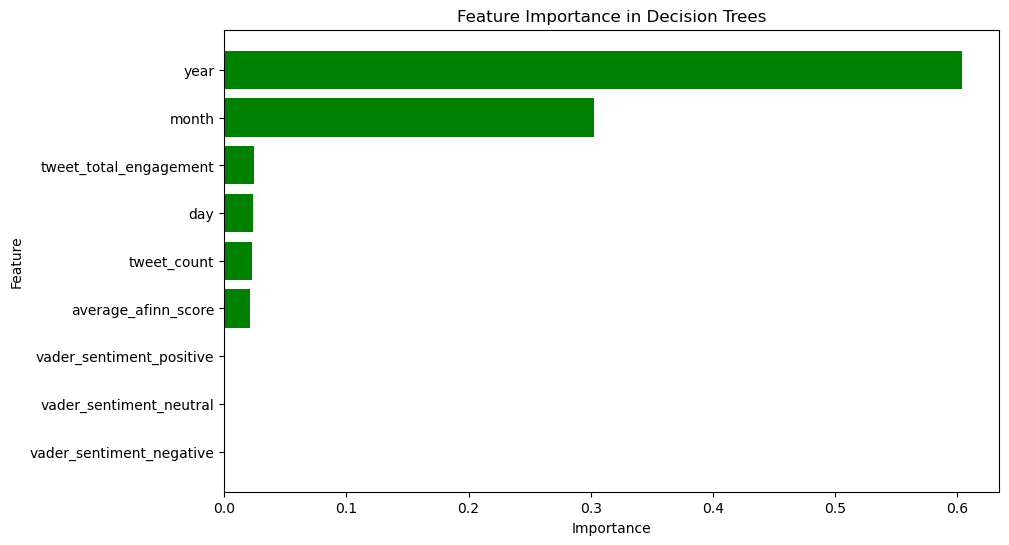

In [27]:
# Get feature importances
feature_importances = best_gradient_boosting_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': tsla_df_x.drop(columns=['date']).columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importance
# Create the bar graph
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="green")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Trees')
plt.gca().invert_yaxis()  # Reverse the order of features for better visualization
plt.show()